In [40]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [41]:
# Tz
class MonotonicLinear(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size  = input_size
    self.output_size = output_size
    self.weights = torch.nn.Parameter(torch.rand((output_size, input_size), dtype=torch.float32))

  def forward(self, x):
    z = torch.mm(x, torch.exp(self.weights.t()))
    return z

class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1 = MonotonicLinear(1, 3)
    self.input2 = torch.nn.Linear(2, 3)
    self.output = torch.nn.MaxPool1d(3)

  def forward(self, x_m, x_u):
    z1 = self.input1(x_m)
    z2 = self.input2(x_u)
    z = torch.add(z1, z2)
    z = self.output(z)
    return z

Tz = Net()
Tz = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/Tz.pt')

In [42]:
# Thermostat
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input   = torch.nn.Linear(3, 32)
        self.output  = torch.nn.Linear(32, 1)

    def forward(self, x):
        z = torch.tanh(self.input(x))
        z = self.output(z)
        z = torch.relu(100 - torch.relu(z))
        return z

Thermostat = Net()
Thermostat = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/Thermostat.pt')

In [43]:
# Tsa
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1  = MonotonicLinear(2, 32)
    self.hidden1 = MonotonicLinear(32, 1)
    self.input2  = torch.nn.Linear(2, 32)
    self.hidden2 = torch.nn.Linear(32, 1)

  def forward(self, x_m, x_u):
    z1 = torch.tanh(self.input1(x_m))
    z1 = self.hidden1(z1)

    z2 = torch.tanh(self.input2(x_u))
    z2 = self.hidden2(z2)

    z = torch.add(z1, z2)
    return z

Tsa = Net()
Tsa = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/Tsa.pt')

In [44]:
# msa
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input   = torch.nn.Linear(4, 32)
    self.output  = torch.nn.Linear(32, 1)

  def forward(self, x):
    z = torch.selu(self.input(x))
    z = self.output(z)
    return z

msa = Net()
msa = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/msa.pt')

In [45]:
# qrh
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input   = torch.nn.Linear(4, 32)
    self.output  = torch.nn.Linear(32, 1)

  def forward(self, x):
    z = torch.selu(self.input(x))
    z = self.output(z)
    return z

qrh = Net()
qrh = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/qrh.pt')

In [46]:
# Read data
df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

# LEAST SQUARE
ones = np.ones(np.array(df['airflow_desired']).reshape(-1,1).shape)
A = np.concatenate((np.array(df['htg_valve_command']).reshape(-1,1), ones), axis=1)
b = np.copy(np.array(df['airflow_desired']).reshape(-1,1))
p = np.linalg.lstsq(A, b, rcond=None)[0]

def LQ(q):
    return q*p[0] + p[1]

In [47]:
start = 64
end   = 1600

msa_0 = np.array(df['airflow_current']).reshape(-1,1)[start: end]
msa_1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]
msa_2 = np.array(df['airflow_current']).reshape(-1,1)[start+2: end+2]
mc_3  = np.array(df['airflow_desired']).reshape(-1,1)[start+3: end+3]

qrh_0 = np.array(df['htg_valve_position']).reshape(-1,1)[start: end]
qrh_1 = np.array(df['htg_valve_position']).reshape(-1,1)[start+1: end+1]
qrh_2 = np.array(df['htg_valve_position']).reshape(-1,1)[start+2: end+2]
qc_3  = np.array(df['htg_valve_command']).reshape(-1,1)[start+3: end+3]

Tca_2 = np.array(df['ahu_supply_temp']).reshape(-1,1)[start+2: end+2]

Tsa_1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
Tsa_2 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+2: end+2]

Tz_2  = np.array(df['room_temp']).reshape(-1,1)[start+2: end+2]
Tz_3  = np.array(df['room_temp']).reshape(-1,1)[start+3: end+3]

clg_sp       = np.array(df['clg_sp_current']).reshape(-1,1)[start+3: end+3]
htg_sp       = np.array(df['htg_sp_current']).reshape(-1,1)[start+3: end+3]
htg_clg_mode = 1*np.array(df['htg_clg_mode']).reshape(-1,1)[start+3: end+3]
Tsp_3        = htg_sp*htg_clg_mode + clg_sp*(1-htg_clg_mode)

In [48]:
def NormalizeData(data, min, max):
    return 100*(data-min)/(max-min)

def DeNormalizeData(scaled_data, min, max):
    return min + scaled_data*(max-min)/100

In [49]:
msa0 = msa_0[0].reshape(-1,1)
msa1 = msa_1[0].reshape(-1,1)
msa2 = msa_2[0].reshape(-1,1)
mc3  =  mc_3[0].reshape(-1,1)
qrh0 = qrh_0[0].reshape(-1,1)
qrh1 = qrh_1[0].reshape(-1,1)
qrh2 = qrh_2[0].reshape(-1,1)
qc3  =  qc_3[0].reshape(-1,1)
Tsa1 = Tsa_1[0].reshape(-1,1)
Tsa2 = Tsa_2[0].reshape(-1,1)
Tca2 = Tca_2[0].reshape(-1,1)
Tz2  =  Tz_2[0].reshape(-1,1)
Tsp3 = Tsp_3[0].reshape(-1,1)

# horizon length
n = 1500
T = np.array([])
for i in range(n):
    with torch.no_grad():
        # COMPUTE
        x = np.concatenate((mc3, msa0, msa1, msa2), axis=1)
        x = NormalizeData(x, 400, 1000)
        x = torch.tensor(x, dtype=torch.float32)
        msa3 = msa(x)
        msa3 = torch.relu(msa3) - torch.relu(msa3 - 100)
        msa3 = DeNormalizeData(msa3, 400, 1000)

        x = np.concatenate((qc3, qrh0, qrh1, qrh2), axis=1)
        x = torch.tensor(x, dtype=torch.float32)
        qrh3 = qrh(x)
        qrh3 = torch.relu(qrh3) - torch.relu(qrh3 - 100)

        x1 = np.concatenate((Tca2, qrh3), axis=1)
        x1 = torch.tensor(x1, dtype=torch.float32)
        x2 = np.concatenate((Tsa1, Tsa2), axis=1)
        x2 = torch.tensor(x2, dtype=torch.float32)
        Tsa3 = Tsa(x1, x2)

        x1 = torch.tensor(np.copy(Tsa3), dtype=torch.float32)
        x2 = np.concatenate((Tz2, msa3), axis=1)
        x2 = torch.tensor(x2, dtype=torch.float32)
        Tz3 = Tz(x1, x2)

        x = np.concatenate((Tsp3, Tz3, qc3), axis=1)
        x = torch.tensor(x, dtype=torch.float32)
        qc4 = Thermostat(x)

        mc4 = LQ(qc4)

        # UPDATE
        mc3  = np.copy(mc4).reshape(-1,1)
        msa0 = np.copy(msa1).reshape(-1,1)
        msa1 = np.copy(msa2).reshape(-1,1)
        msa2 = np.copy(msa3).reshape(-1,1)

        qc3  = np.copy(qc4).reshape(-1,1)
        qrh0 = np.copy(qrh1).reshape(-1,1)
        qrh1 = np.copy(qrh2).reshape(-1,1)
        qrh2 = np.copy(qrh3).reshape(-1,1)

        Tca2 = Tca_2[i+1].reshape(-1,1)
        Tsa1 = np.copy(Tsa2).reshape(-1,1)
        Tsa2 = np.copy(Tsa3).reshape(-1,1)

        Tz2 = np.copy(Tz3).reshape(-1,1)

        Tsp3 = Tsp_3[i+1].reshape(-1,1)

        # save Tz
        T = np.append(T, Tz3)

In [50]:
np.mean(np.abs(T - Tz_3[0:n,0]))

5.155017357381185

In [51]:
r2_score(Tz_3[0:n,0], T)

-7.741880855535685

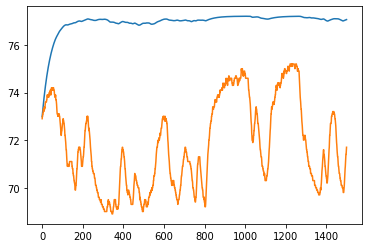

In [52]:
plt.plot(T)
plt.plot(Tz_3[0:n,0])
plt.show()